# ARES
This is a documentation for using `fit_param.py` to fit dark matter mass and the R.M.S. stream velocity between dark matter and gas, given the 21-cm temperature and its correponding redshift.

## Technical Details
The work is based on [Muñoz et al., 2015](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.92.083528), which discussed the heating of baryons due to scattering with dark matter during the dark ages.

We added `average_dTb.py` and `fit_param.py` to the original version of [`ARES`](https://ares.readthedocs.io/en/latest/index.html), which was designed to rapidly generate models for the global 21-cm signal.

Be warned: this code is still under active development – use at your own risk! Correctness of results is not guaranteed.

## Citation
If you use this code in paper please reference [TBD]() if it’s an application of fitting dark matter mass and R.M.S. of stream velocity.

## Dependencies
You will need:
- numpy
- scipy
- matplotlib
- h5py
- npy_append_array

Note: `ares` has been tested only with Python 3.7.x.

## Getting started
To clone a copy and install:
```
git clone https://github.com/Xsmos/ares.git
cd ares
python setup.py install
```

`ares` will look in `ares/input` for more lookup tables of various kinds if you want full function. To download said lookup tables, check out the original [**ares**](https://ares.readthedocs.io/en/latest/install.html) for more details about installing the lookup tables.

## Example

In [1]:
import numpy as np
from fit_param import interp_dTb, fit_param

# assumptions about the dark matter mass and rms stream velocity
m_chi_true = 0.01 # GeV
V_rms_true = 25000 # m/s

noise = 1 # mK. std of the signal noise, assumed to be Gaussian and frequency-independent

N_observations = 5 # number of observations
z_sample = np.arange(10, 300, 10) # redshifts corresponding to these observations

# bounds? ######################################################
cores = 24 # number of CPU

# sampling
dTb_accurate = interp_dTb(param=[m_chi_true, V_rms_true], z=z_sample, cores=cores, N_v_stream=24)
dTb_sample = dTb_accurate + noise * np.random.normal(size=(N_observations, z_sample.shape[0]))

# fitting
fit_param(z_sample, dTb_sample, cores=cores, save_name=f"m_chi{m_chi_true}-V_rms{V_rms_true}.npy", N_v_streams=24)

24 v_streams will be generated for m_chi = 0.01 GeV and V_rms = 25000 m/s...
Sampling 24 dTb's by 24 CPUs parallelly...
It costs 0:00:09.851225 to calculate dTb of 24 different initial_v_streams by 24 CPU(s).
---------------------------------------------
24 v_streams will be generated for m_chi = 0.1 GeV and V_rms = 29000.0 m/s...
Sampling 24 dTb's by 24 CPUs parallelly...
It costs 0:00:09.907761 to calculate dTb of 24 different initial_v_streams by 24 CPU(s).
---------------------------------------------
24 v_streams will be generated for m_chi = 0.2 GeV and V_rms = 29000.0 m/s...
Sampling 24 dTb's by 24 CPUs parallelly...
It costs 0:00:08.487266 to calculate dTb of 24 different initial_v_streams by 24 CPU(s).
---------------------------------------------
24 v_streams will be generated for m_chi = 0.1 GeV and V_rms = 31900.0 m/s...
Sampling 24 dTb's by 24 CPUs parallelly...
It costs 0:00:09.264237 to calculate dTb of 24 different initial_v_streams by 24 CPU(s).
-----------------------

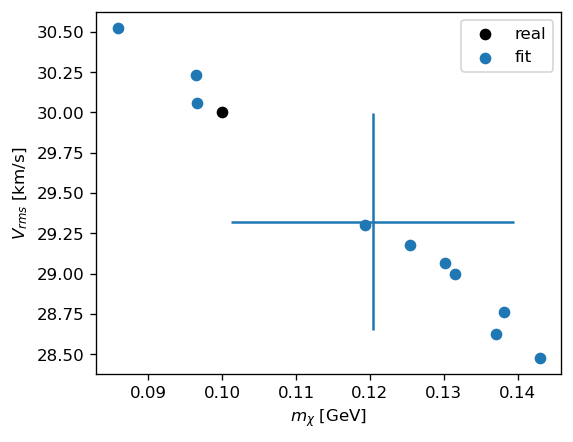

In [43]:
import os
import matplotlib.pyplot as plt

fig = plt.figure(dpi=120, figsize=(5,4))
for filename in os.listdir():
    if ".npy" in filename:
        real_value = filename.split(sep="-")
        fit_data = np.load(filename)
        fit_mean = np.mean(fit_data, axis=0)
        plt.scatter(float(real_value[0][5:]), float(real_value[1][5:-4])/1000, c='k', label="real")
        plt.scatter(fit_data[:,0], fit_data[:,1]/1000, label="fit")
        plt.errorbar(fit_mean[0], fit_mean[1]/1000, xerr=np.std(fit_data[:,0]), yerr=np.std(fit_data[:,1])/1000)
        plt.xlabel(r"$m_{\chi}$ [GeV]")
        plt.ylabel(r"$V_{rms}$ [km/s]")
        plt.legend()
        plt.show()

In [16]:
real_value

['m_chi0.1', 'V_rms30000.npy']

## Useful parameters:
- adequate_random_v_streams